# **Import the data:**

In [1]:
import os
import random
import torch
from torch import nn, optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter


In [2]:
from google.colab import drive
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/Dataset'
healthy_path = os.path.join(dataset_path, 'Healthy')
autism_path = os.path.join(dataset_path, 'Autistic')
ndd_path = os.path.join(dataset_path, 'NDD')


Mounted at /content/drive


# **Data Transformations:**

In [ ]:
random.seed(42)
torch.manual_seed(42)

save_dir = "/content/drive/MyDrive/processed_data"
os.makedirs(save_dir, exist_ok=True)

# Data transformations
preprocess_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1))])


# Label mapping
label_mapping = {'Healthy': 0, 'Autistic': 1, 'NDD': 2}
data = []

for label_name, path in [('Healthy', healthy_path), ('Autistic', autism_path), ('NDD', ndd_path)]:
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        data.append((img_path, label_mapping[label_name]))

print(f"Total images: {len(data)}")

Total images: 4410


In [ ]:
class_counts = Counter([label for _, label in data])
print("Class distribution:", class_counts)

Class distribution: Counter({0: 1470, 1: 1470, 2: 1470})


## **Data Preprocessing and Splitting:**

In [ ]:
# # Split dataset into train (70%), validation (15%), and test (15%)
# train_ratio, val_ratio, test_ratio = 0.70, 0.15, 0.15
# train_data, temp_data = train_test_split(data, test_size=(val_ratio + test_ratio), random_state=42, stratify=[label for _, label in data])
# val_data, test_data = train_test_split(temp_data, test_size=0.50, random_state=42, stratify=[label for _, label in temp_data])

# # Augment training data
# augmented_train_data = []
# for image_path, label in tqdm(train_data, desc="Processing training images", unit="image"):
#     image = Image.open(image_path).convert("RGB")
#     augmented_train_data.append((preprocess_transforms(image), label))  # Original
#     augmented_image = augmentation_transforms(image)  # Apply augmentation
#     augmented_train_data.append((preprocess_transforms(augmented_image), label))  # Then apply preprocessing

# # Convert validation and test data
# def process_images(data):
#     return [(preprocess_transforms(Image.open(image_path).convert("RGB")), label) for image_path, label in data]

# val_data = process_images(val_data)
# test_data = process_images(test_data)

# # Convert to TensorDataset and DataLoader
# def create_dataloader(data, batch_size=32, shuffle=True):
#     images, labels = zip(*data)
#     return DataLoader(TensorDataset(torch.stack(images), torch.tensor(labels)), batch_size=batch_size, shuffle=shuffle)

# train_loader = create_dataloader(augmented_train_data)
# val_loader = create_dataloader(val_data, shuffle=False)
# test_loader = create_dataloader(test_data, shuffle=False)

# # Save processed datasets
# torch.save(augmented_train_data, os.path.join(save_dir, "train_data.pt"))
# torch.save(val_data, os.path.join(save_dir, "val_data.pt"))
# torch.save(test_data, os.path.join(save_dir, "test_data.pt"))

# print("Datasets saved successfully to:", save_dir)

# **Load the preprocessed data:**

In [ ]:
# Load datasets
train_data = torch.load(os.path.join(save_dir, "train_data.pt"))
val_data = torch.load(os.path.join(save_dir, "val_data.pt"))
test_data = torch.load(os.path.join(save_dir, "test_data.pt"))

print("Datasets loaded successfully!")

def create_dataloader(data, batch_size=32, shuffle=True):
    images, labels = zip(*data)
    images = torch.stack(images)
    labels = torch.tensor(labels)
    return DataLoader(TensorDataset(images, labels), batch_size=batch_size, shuffle=shuffle)

train_loader = create_dataloader(train_data, shuffle=True)
val_loader = create_dataloader(val_data, shuffle=False)
test_loader = create_dataloader(test_data, shuffle=False)

print("DataLoaders are ready for training and evaluation!")


Datasets loaded successfully!
DataLoaders are ready for training and evaluation!


# **EfficientNet_B0 Model:**

In [ ]:
# Load the pretrained EfficientNet_B0 model
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False

for param in model.features[-2:].parameters():
    param.requires_grad = True

model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(model.classifier[1].in_features, 512),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(512, len(label_mapping))
)

model.to(device)

# Loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5, min_lr=1e-6, verbose=True)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 136MB/s] 
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

# **Train the model:**

<ipython-input-9-e881e5c364e6>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-9-e881e5c364e6>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 1/50
Train Loss: 0.8957, Train Accuracy: 0.6278
Val Loss: 0.7296, Val Accuracy: 0.7352

Epoch 2/50
Train Loss: 0.6835, Train Accuracy: 0.7707
Val Loss: 0.6504, Val Accuracy: 0.7746

Epoch 3/50
Train Loss: 0.6339, Train Accuracy: 0.7993
Val Loss: 0.6289, Val Accuracy: 0.7958

Epoch 4/50
Train Loss: 0.5991, Train Accuracy: 0.8260
Val Loss: 0.6078, Val Accuracy: 0.8124

Epoch 5/50
Train Loss: 0.5702, Train Accuracy: 0.8372
Val Loss: 0.5969, Val Accuracy: 0.8215

Epoch 6/50
Train Loss: 0.5526, Train Accuracy: 0.8570
Val Loss: 0.5888, Val Accuracy: 0.8260

Epoch 7/50
Train Loss: 0.5350, Train Accuracy: 0.8675
Val Loss: 0.5783, Val Accuracy: 0.8366

Epoch 8/50
Train Loss: 0.5181, Train Accuracy: 0.8795
Val Loss: 0.5802, Val Accuracy: 0.8411

Epoch 9/50
Train Loss: 0.5073, Train Accuracy: 0.8873
Val Loss: 0.5794, Val Accuracy: 0.8411

Epoch 10/50
Train Loss: 0.4878, Train Accuracy: 0.8988
Val Loss: 0.5802, Val Accuracy: 0.8381

Epoch 11/50
Train Loss: 0.4744, Train Accuracy: 0.9082
Val

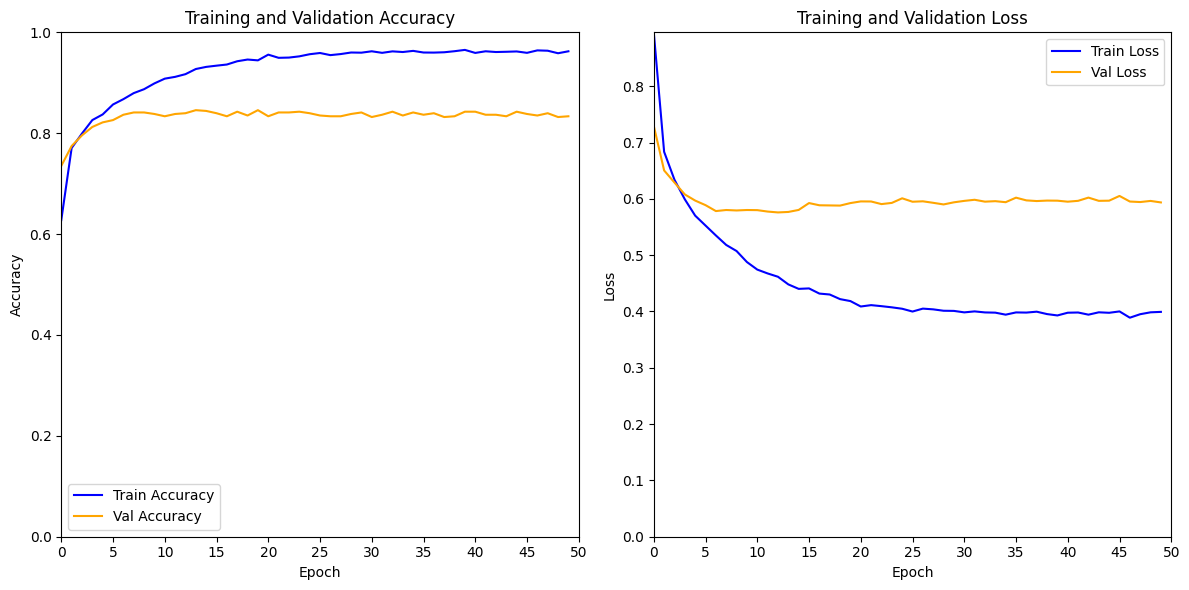

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, patience=5):
    best_val_loss, best_val_acc, epochs_without_improvement = float('inf'), 0.0, 0
    scaler = torch.cuda.amp.GradScaler()

    train_accuracies, val_accuracies, train_losses, val_losses = [], [], [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                correct += (outputs.argmax(1) == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = correct / total
        scheduler.step(val_loss)

        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

        # if val_loss < best_val_loss or val_acc > best_val_acc:
        #     best_val_loss, best_val_acc = val_loss, val_acc
        #     epochs_without_improvement = 0
        # else:
        #     epochs_without_improvement += 1
        #     if epochs_without_improvement >= patience:
        #         print("Early stopping...")
        #         break


        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(val_accuracies, label='Val Accuracy', color='orange')
    plt.xticks(np.arange(0, num_epochs + 1, max(1, num_epochs // 10)))
    plt.xlim(0, num_epochs)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Val Loss', color='orange')
    plt.xticks(np.arange(0, num_epochs + 1, max(1, num_epochs // 10)))
    plt.xlim(0, num_epochs)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(0, max(max(train_losses), max(val_losses)))
    plt.legend()

    plt.tight_layout()
    plt.show()


# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50)


# **Save the model:**

In [ ]:
# Save model weights
checkpoint_path = "/content/drive/MyDrive/autism_model_weights_effeicientNet.pth"
torch.save(model.state_dict(), checkpoint_path)

print(f"Model weights saved successfully at {checkpoint_path}")


Model weights saved successfully at /content/drive/MyDrive/autism_model_weights_effeicientNet.pth


In [ ]:
# Save the model
model_path = "/content/drive/MyDrive/autism_model_effeicientNet.pth"
torch.save(model, model_path)
print(f"Model saved successfully at {model_path}")


Model saved successfully at /content/drive/MyDrive/autism_model_effeicientNet.pth


# **Evaluate the model:**

In [ ]:
# Evaluate on test set
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 87.16%


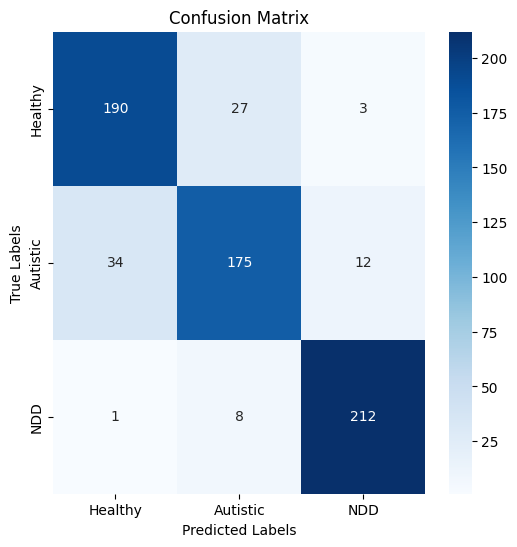

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.84      0.86      0.85       220
    Autistic       0.83      0.79      0.81       221
         NDD       0.93      0.96      0.95       221

    accuracy                           0.87       662
   macro avg       0.87      0.87      0.87       662
weighted avg       0.87      0.87      0.87       662



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report:
report = classification_report(true_labels, predicted_labels, target_names=list(label_mapping.keys()))
print("Classification Report:")
print(report)


# **Visualize the results:**

-SNE scatter plot:

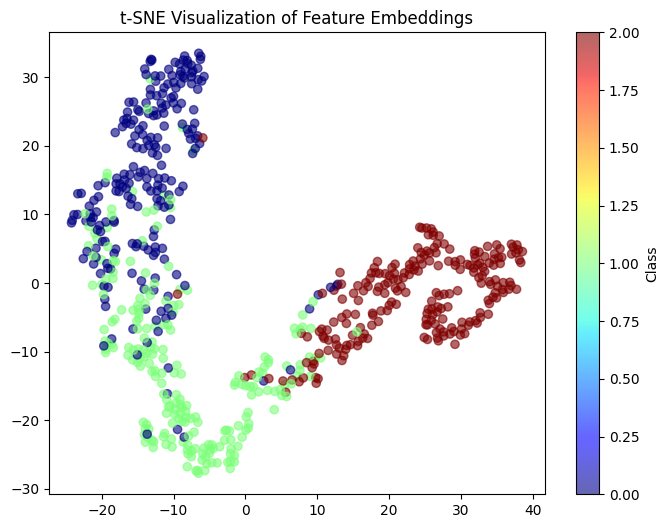

In [ ]:
from sklearn.manifold import TSNE

model.eval()
features = []
labels_list = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        features.append(outputs.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

features = np.concatenate(features)
labels_list = np.concatenate(labels_list)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_2d = tsne.fit_transform(features)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels_list, cmap='jet', alpha=0.6)
plt.colorbar(scatter, label="Class")
plt.title("t-SNE Visualization of Feature Embeddings")
plt.show()


ROC curve:

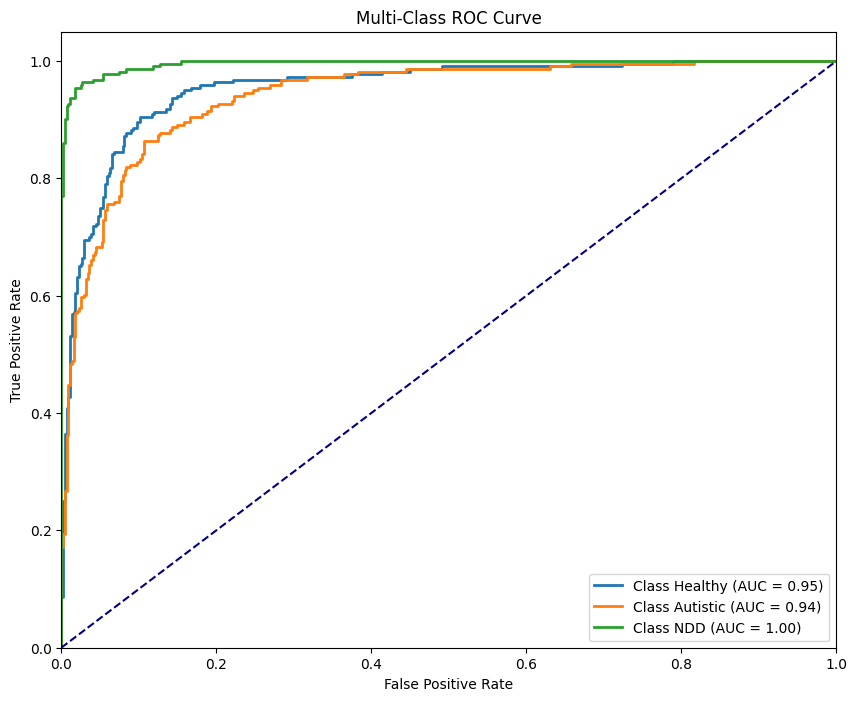

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

num_classes = len(label_mapping)

true_labels = []
predicted_probs = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities

        true_labels.extend(labels.cpu().numpy())
        predicted_probs.extend(probs.cpu().numpy())

true_labels = np.array(true_labels)
predicted_probs = np.array(predicted_probs)

# Convert true labels to one-hot encoding
true_labels_one_hot = label_binarize(true_labels, classes=np.arange(num_classes))

# Compute ROC Curve and AUC for each class
plt.figure(figsize=(10, 8))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(true_labels_one_hot[:, i], predicted_probs[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'Class {list(label_mapping.keys())[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend(loc="lower right")
plt.show()


Top 3 classes:

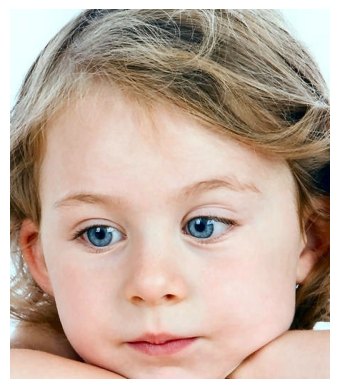

Top 3 Predictions:
Class: Autistic, Probability: 0.9704
Class: NDD, Probability: 0.0184
Class: Healthy, Probability: 0.0112


In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torch
import torch.nn.functional as F

def preprocess_image(image):
    """
    Preprocesses the image (resize, convert to RGB, tensor conversion, normalization).
    """
    image = image.convert("RGB")
    image = image.resize((224, 224))
    image = transforms.ToTensor()(image)
    image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)
    return image

def predict_top_3_classes(image_path, model, label_mapping, device):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    image_tensor = preprocess_image(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)

    top3_probabilities, top3_indices = torch.topk(probabilities, 3, dim=1)

    top3_classes = [list(label_mapping.keys())[i] for i in top3_indices[0]]

    print("Top 3 Predictions:")
    for i in range(3):
        print(f"Class: {top3_classes[i]}, Probability: {top3_probabilities[0][i].item():.4f}")

image_path = '/content/drive/MyDrive/new-data-for-testing/Autism_test.jpg'
predict_top_3_classes(image_path, model, label_mapping, device)


# **Interpretability with Grad-CAM (XAI):**

In [3]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torchvision.models import convnext

torch.serialization.add_safe_globals({'ConvNeXt': convnext.ConvNeXt})

model_path = "/content/drive/MyDrive/autism_model_effeicientNet.pth"
model = torch.load(model_path, map_location=device, weights_only=False)
model.eval()
model.to(device)


# Store activations and gradients
activations = []
gradients = []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

# Register hooks on the final feature layer
try:
    target_layer = model.features[-1][0]
except AttributeError:
    raise RuntimeError("Model does not have a 'features' attribute. Update the hook layer accordingly.")

target_layer.register_forward_hook(forward_hook)
target_layer.register_full_backward_hook(backward_hook)

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(image).unsqueeze(0).to(device)

def grad_cam(image_path, model):
    activations.clear()
    gradients.clear()

    input_tensor = preprocess_image(image_path)
    output = model(input_tensor)
    class_idx = output.argmax(dim=1).item()

    model.zero_grad()
    output[0, class_idx].backward()

    act = activations[0]
    grad = gradients[0]
    weights = grad.mean(dim=(2, 3), keepdim=True)
    cam = (weights * act).sum(dim=1).squeeze().cpu().detach().numpy()

    cam = np.maximum(cam, 0)
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-8)

    return cam, class_idx

def visualize_cam(image_path, cam):
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    height, width, _ = original_image.shape

    cam = cv2.resize(cam, (width, height))
    heatmap = np.uint8(255 * cam)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(original_image, 0.5, heatmap, 0.5, 0)

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()


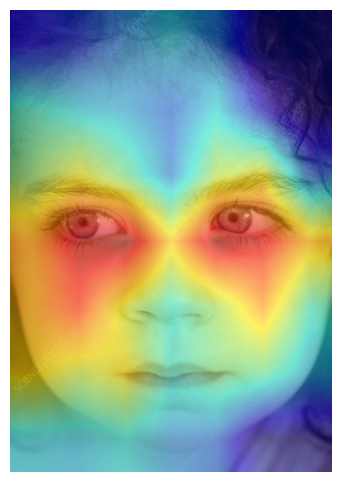

Predicted Class Index: 0


In [4]:
image_path = "/content/drive/MyDrive/new-data-for-testing/healthy_test.jpg"
cam, predicted_class = grad_cam(image_path, model)
visualize_cam(image_path, cam)

print(f"Predicted Class Index: {predicted_class}")

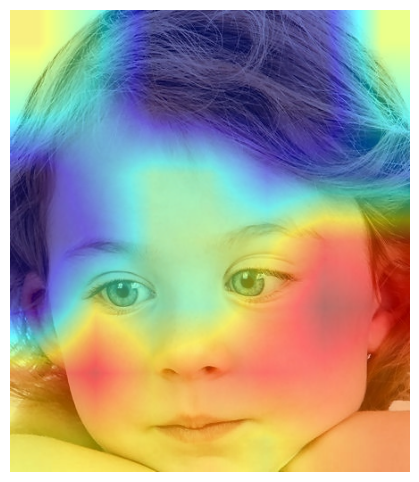

Predicted Class Index: 1


In [5]:
image_path = "/content/drive/MyDrive/new-data-for-testing/Autism_test.jpg"
cam, predicted_class = grad_cam(image_path, model)
visualize_cam(image_path, cam)

print(f"Predicted Class Index: {predicted_class}")

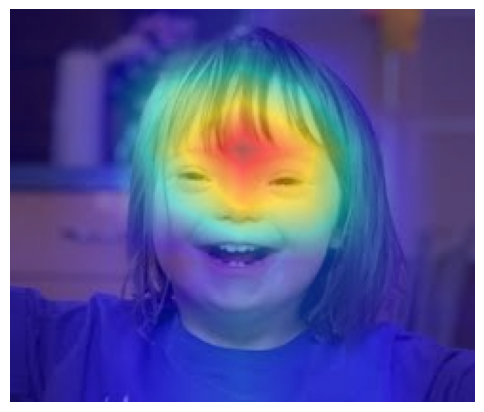

Predicted Class Index: 2


In [6]:
image_path = "/content/drive/MyDrive/new-data-for-testing/NDD_test.jpg"
cam, predicted_class = grad_cam(image_path, model)
visualize_cam(image_path, cam)

print(f"Predicted Class Index: {predicted_class}")

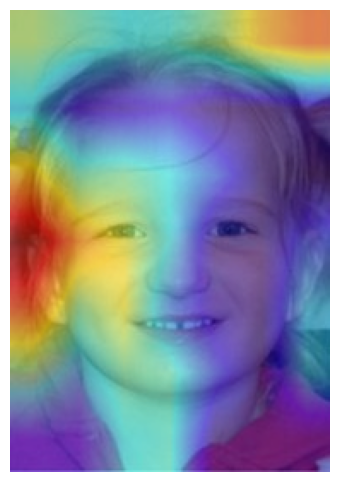

Predicted Class Index: 1


In [7]:
image_path = "/content/drive/MyDrive/Dataset/NDD/NDD_duplication_syndrome20.jpg"
cam, predicted_class = grad_cam(image_path, model)
visualize_cam(image_path, cam)

print(f"Predicted Class Index: {predicted_class}")

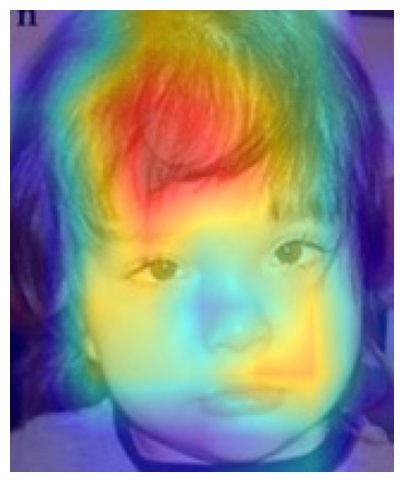

Predicted Class Index: 2


In [8]:
image_path = "//content/drive/MyDrive/Dataset/NDD/NDD_deletion_syndrome18.jpg"
cam, predicted_class = grad_cam(image_path, model)
visualize_cam(image_path, cam)

print(f"Predicted Class Index: {predicted_class}")